In [297]:
import pandas as pd
import math
from time import sleep
from opencage.geocoder import OpenCageGeocode

from emoji import UNICODE_EMOJI
from topics import *
from scipy import spatial

In [298]:
data = pd.read_csv('data/tinder_profile_data.csv')

In [299]:
data.head()

,name,age,college,job,city,gender,distance,details,anthem,profile_pic_urls
0,Miranda,19.0,Concordia University,NaN,NaN,NaN,3722 kilometers away,From BC and I need to learn French ASAP\nInsta...,NaN,['https://images-ssl.gotinder.com/5d5b662cd8e2...
1,Miranda,19.0,Concordia University,NaN,NaN,NaN,3722 kilometers away,From BC and I need to learn French ASAP\nInsta...,NaN,['https://images-ssl.gotinder.com/5d5b662cd8e2...
2,Katherine,19.0,John Abbott College,NaN,NaN,NaN,3706 kilometers away,Single and ready to mingle\n •reina del perreo...,NaN,['https://images-ssl.gotinder.com/5e2ce3ab2f20...
3,Katie,19.0,NaN,NaN,NaN,NaN,3584 kilometers away,just a cupcake looking for a stud muffin \n18,NaN,['https://images-ssl.gotinder.com/5ce837a007db...
4,Megan,19.0,McMaster University,NaN,NaN,Woman,3613 kilometers away,NaN,NaN,['https://images-ssl.gotinder.com/5e0ab1dfd5d4...


In [300]:
stop_words = set(stopwords.words('english')) 
bad_chars = ["\n","\r",'\'','"',',','.','(',')','&','!','?',':','-','`','...','..','/']
for each in bad_chars:
    stop_words.add(each)

In [301]:
def clean(data):
    '''
    Remove any missing data
    Remove duplicates
    Convert to correct data types
    Parse Strings
    Return dataframe
    '''
    print("-----------------")
    print("CLEANING DATA")
    print("...")
    print("FOUND {} ENTRIES".format(len(data)))
    empty_entries = data.name.isna()
    data = data[-empty_entries]
    print("REMOVED {} EMPTY ENTRIES".format(empty_entries.sum()))
    duplicated_entries = data.duplicated()
    data = data[-duplicated_entries]
    print("REMOVED {} DUPLICATED ENTRIES".format(duplicated_entries.sum()))
    print("{} ENTRIES REMAIN".format(len(data)))
    
    # Data conversions to be added into webscraping script
    data.name = data.name.apply(lambda x: x.capitalize())
    data.age = data.age.apply(lambda x: int(x) if not np.isnan(x) else x)
    data.city = data.city.apply(lambda x: x[9:] if type(x) != float else x)
    data.distance = data.distance.apply(lambda x: int(x.split(' ')[0]) if type(x) != float else x)
    data['filtered_details'] = data[-data.details.isna()].details.apply(lambda x: filter_details(x))
    
    return data

In [302]:
def filter_details(text):
    word_tokens = word_tokenize(text.lower())
    word_tokens = set(word_tokens)
    filtered = word_tokens - stop_words
    return filtered

In [303]:
data = clean(data)

-----------------
CLEANING DATA
...
FOUND 2516 ENTRIES
REMOVED 2 EMPTY ENTRIES
REMOVED 4 DUPLICATED ENTRIES
2510 ENTRIES REMAIN


In [304]:
def topic_check(filtered_details,topic):
    if filtered_details.intersection(topics[topic]) != set():
        return True
    return False

In [305]:
def second_check(filtered_details,existing,topic):
    if existing == True:
        return True
    for word in list(filtered_details):
        for each in second_pass[topic]:
            if each in word:
                return True
    return False

In [306]:
def add_topics(data):
    for each in topics:
        data[each] = data[-data.filtered_details.isna()].filtered_details.apply(lambda x: topic_check(x,each))
    
    for each in second_pass:
        data[each] = data[-data.filtered_details.isna()].apply(lambda x: second_check(x.filtered_details,x[each],each),axis=1)
    return data

In [307]:
data.head()

,name,age,college,job,city,gender,distance,details,anthem,profile_pic_urls,filtered_details
0,Miranda,19.0,Concordia University,NaN,NaN,NaN,3722.0,From BC and I need to learn French ASAP\nInsta...,NaN,['https://images-ssl.gotinder.com/5d5b662cd8e2...,"{need, asap, bc, miranda.coombes, learn, frenc..."
2,Katherine,19.0,John Abbott College,NaN,NaN,NaN,3706.0,Single and ready to mingle\n •reina del perreo...,NaN,['https://images-ssl.gotinder.com/5e2ce3ab2f20...,"{del, •reina, 🥵, fr, mingle, ready, single, 🇨🇴..."
3,Katie,19.0,NaN,NaN,NaN,NaN,3584.0,just a cupcake looking for a stud muffin \n18,NaN,['https://images-ssl.gotinder.com/5ce837a007db...,"{looking, stud, cupcake, 18, muffin}"
4,Megan,19.0,McMaster University,NaN,NaN,Woman,3613.0,NaN,NaN,['https://images-ssl.gotinder.com/5e0ab1dfd5d4...,NaN
5,Abby,18.0,NaN,NaN,NaN,NaN,3616.0,Insta:abby.linton,NaN,['https://images-ssl.gotinder.com/5ea8d2a0ce3a...,"{abby.linton, insta}"


In [308]:
topics = {}
topics['instagram'] = {'ig','insta','i̇nsta','instagram','📷','📸','@','ig-','instagram-','insta-','insta/','ig:'}
topics['snapchat'] = {'sc','snap','snapchat','👻','sc-','snapchat-','snap-'}
topics['covid19'] = {'corona','coronavirus','cv','quarantine','quarantini','covid','covid19','virus','sick','covid-19','wfh','work from home','social distancing','shelter','apocalypse','2020', 'SARS', 'flu', 'mask', 'toilet paper','pandemic', 'zoom'}
topics['cannabis'] = {'weed','420','420 friendly', 'maryjane','smoke','blaze','marijuana','blunt','bong','joint','high','drug','drugs','cannabis','CDB', 'THC', }
topics['alcohol'] = {'drink','drinks','alcohol','shot','shots','happy hour','beer','wine','bar','vodka','whiskey','tequila','rum','gin','brewery','vineyard','distillery','🥃','🍷','🍾','🍸','🍹','🍺','🍻','🥂'}
topics['tv'] = {'netflix','tv','show','hulu','movies','movie','watch','series','youtube', 'season', 'office', 'pam', 'jim', 'dwight', 'himym'}
topics['hobbies'] = {'cooking', 'dancing', 'singing', 'running', 'jogging', 'gym', 'horse', 'reading', 'painting', 'drawing', 'photography', 'photographer', 'swimming', 'board games', 'acting', 'theatre', 'gaming', 'music', 'succulent', 'fashion', 'cosplay', 'musician'}

second_pass = {}
second_pass['instagram'] = ['ig-','ig:','insta','instagram']
second_pass['snapchat'] = ['sc-','sc:','snap','snapchat']

In [309]:
data = add_topics(data)

In [310]:
data.head()

,name,age,college,job,city,gender,distance,details,anthem,profile_pic_urls,filtered_details,instagram,snapchat,covid19,cannabis,alcohol,tv,hobbies
0,Miranda,19.0,Concordia University,NaN,NaN,NaN,3722.0,From BC and I need to learn French ASAP\nInsta...,NaN,['https://images-ssl.gotinder.com/5d5b662cd8e2...,"{need, asap, bc, miranda.coombes, learn, frenc...",True,False,False,False,False,False,False
2,Katherine,19.0,John Abbott College,NaN,NaN,NaN,3706.0,Single and ready to mingle\n •reina del perreo...,NaN,['https://images-ssl.gotinder.com/5e2ce3ab2f20...,"{del, •reina, 🥵, fr, mingle, ready, single, 🇨🇴...",False,False,False,False,False,False,False
3,Katie,19.0,NaN,NaN,NaN,NaN,3584.0,just a cupcake looking for a stud muffin \n18,NaN,['https://images-ssl.gotinder.com/5ce837a007db...,"{looking, stud, cupcake, 18, muffin}",False,False,False,False,False,False,False
4,Megan,19.0,McMaster University,NaN,NaN,Woman,3613.0,NaN,NaN,['https://images-ssl.gotinder.com/5e0ab1dfd5d4...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Abby,18.0,NaN,NaN,NaN,NaN,3616.0,Insta:abby.linton,NaN,['https://images-ssl.gotinder.com/5ea8d2a0ce3a...,"{abby.linton, insta}",True,False,False,False,False,False,False


In [311]:
data['hobbies'].sum()

68

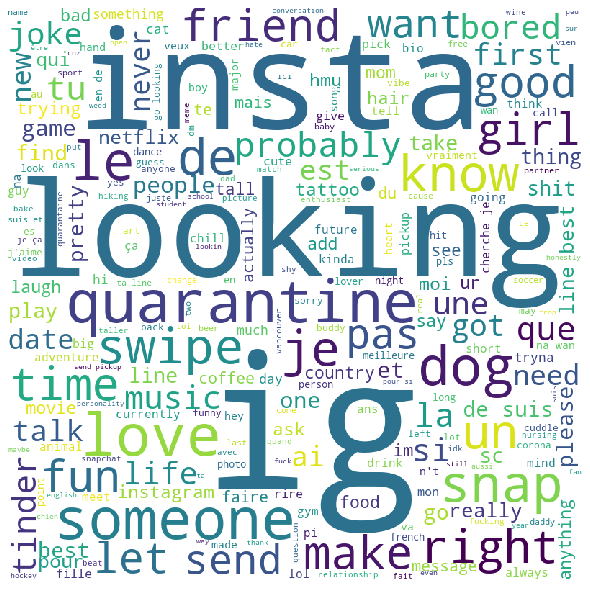

In [312]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

comment_words = ""
words = data[-data.filtered_details.isna()].filtered_details.to_list()
for each in words:
    for i in each:
        comment_words += ' '+i
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                max_words = 500, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [313]:
total = len(data)

def word_mention():
    for each in topics:
        nums = data[each].sum()
        print(f'{nums} ENTRIED MENTIONED {each.upper()} ({str(round(100*nums/total,1))}%)')

word_mention()

397 ENTRIED MENTIONED INSTAGRAM (15.8%)
98 ENTRIED MENTIONED SNAPCHAT (3.9%)
104 ENTRIED MENTIONED COVID19 (4.1%)
20 ENTRIED MENTIONED CANNABIS (0.8%)
64 ENTRIED MENTIONED ALCOHOL (2.5%)
54 ENTRIED MENTIONED TV (2.2%)
68 ENTRIED MENTIONED HOBBIES (2.7%)
